# Dual_vision测试

In [1]:
import matplotlib.pyplot as plt
import env.guide_sim_dual as gs
import params
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib
from matplotlib import animation
import random
import os

pygame 2.6.1 (SDL 2.28.4, Python 3.11.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
import matplotlib
from matplotlib import animation
from ipywidgets.widgets import HTML
def display_video(frames:list, framerate:int=30, dpi:int=70):
    '''
        在Jupyter Notebook页面中生成视频
    '''
    height, width = frames[0].shape
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg') 
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0], cmap='gray')
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

## 加载导丝仿真环境

In [3]:
dataset_path = "datas/train/"
tasks = os.listdir(os.path.join(dataset_path, "task"))
def _sortfunc(name:str):
    return int(name.split(".")[-2])
tasks.sort(key=_sortfunc)
tasks = [os.path.join(dataset_path, "task", t) for t in tasks]
env = gs.GuidewireEnv(tasks[0])

datas/train/no_angiography/1.png
datas/train/label/1.png
datas/train/images/1.png


## 尝试加载导丝环境

In [3]:
import pygame
env.reff_surf, env.bg_surf
env.reff_surf.get_bitsize()

24

(2, 256, 256)


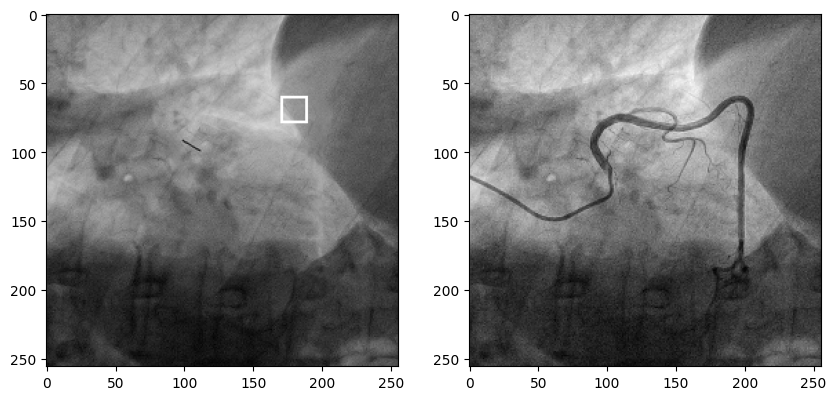

In [4]:
img = env.reset()  # 重置环境（每次要开始交互之前必须这么做）（输入代表根据序号开启某个任务）
print(img.shape)

def dual_display(img:np.ndarray):
    # 显示子图，分别显示img[0]和img[1]
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img[0], cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(img[1], cmap='gray')
dual_display(img)

In [5]:
def img_ploter(states:np.ndarray, titles:list) -> plt.Figure:
    """将状态画成图，用于暂存到tensorboard中"""
    num_figs = 0
    if isinstance(states, np.ndarray):
        num_figs = states.shape[0]
    elif isinstance(states, list):
        num_figs = len(states)
    num_rows = num_figs // 5 + 1
    # 生成5列n行的子图
    fig, axs = plt.subplots(num_rows, 5, figsize=(15, num_rows*3))
    now_row = 0
    for i, state in enumerate(states):
        # state: [2, h, w]
        # 每5个子图后换行
        # 构造一个[h, 2w]的图片，把states的两个通道展示到一张宽图像上
        show_arr = np.zeros((state.shape[1], state.shape[2]*2))
        show_arr[:, :state.shape[2]] = state[0]
        show_arr[:, state.shape[2]:] = state[1]
        if num_rows == 1:
            axs[i%5].imshow(show_arr, cmap="gray")
            axs[i%5].axis('off')
            axs[i%5].set_title(titles[i])
        else:
            axs[now_row, i%5].imshow(show_arr, cmap="gray")
            axs[now_row, i%5].axis('off')
            axs[now_row, i%5].set_title(titles[i])
        if i%5 == 4:
            now_row += 1
    return fig

## 图片做域随机化处理


In [6]:
# 定义转换管道，包括域随机化
transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 随机改变颜色属性
    transforms.RandomResizedCrop(size= (256, 256), scale=(0.95, 1.0)),  # 随机裁剪并调整大小
    transforms.RandomRotation(degrees=2),  # 随机旋转
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=[0.5], std=[0.5])  # 归一化到[-1, 1]之间
])
def dual_sync_transform(s:np.ndarray, transform: transforms.Compose):
    '''
    s 是输入状态, [2, 256, 256]
    需要使得两个图像获得相同的转换
    '''
    tensor = torch.from_numpy(s).to(dtype=torch.uint8)
    tensor = transform(tensor[:,None,...])  # [2, 1, 256, 256]
    return tensor.squeeze(dim=1).numpy()    # [2, 256, 256]

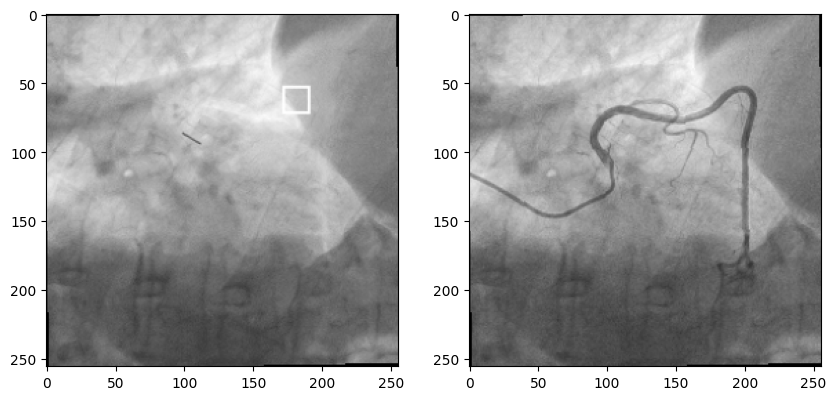

In [7]:
tensor  = dual_sync_transform(img, transform)
dual_display(tensor)

## 尝试交互 (往前推进十次)

24
24
0 -0.3048780487804878 False 1
24
1 0.36585365853658536 False 0
24
2 0.3252032520325203 False 0
24
3 0.5691056910569106 False 0
24
4 1.1788617886178863 False 0
246 192


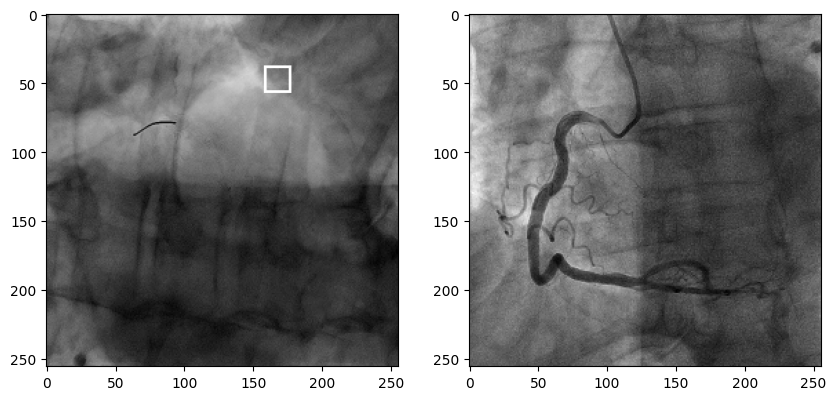

In [4]:
env.reset()
states = []
titles = []
for i in range(5):
    action = random.choice([0, 1])
    img, reward, is_done, _ = env.step(action)  # 执行一个动作（0: 推进， 1： 撤回， 2，3：旋转）
    print(i, reward, is_done, action)
    states.append(img)
    titles.append(f"{i}")
    if is_done:
        break
dual_display(img)
print(env.inial_a_star, env.last_a_star)

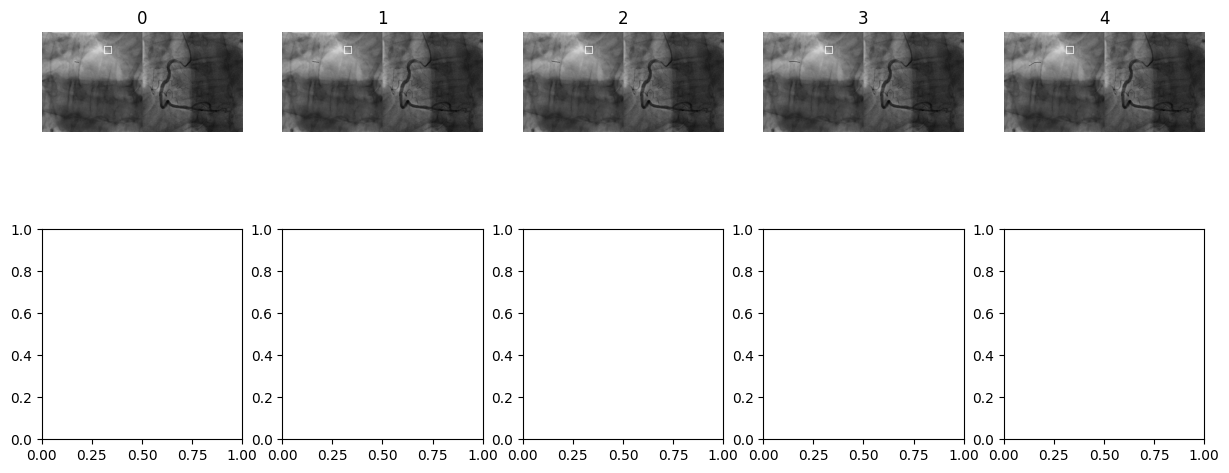

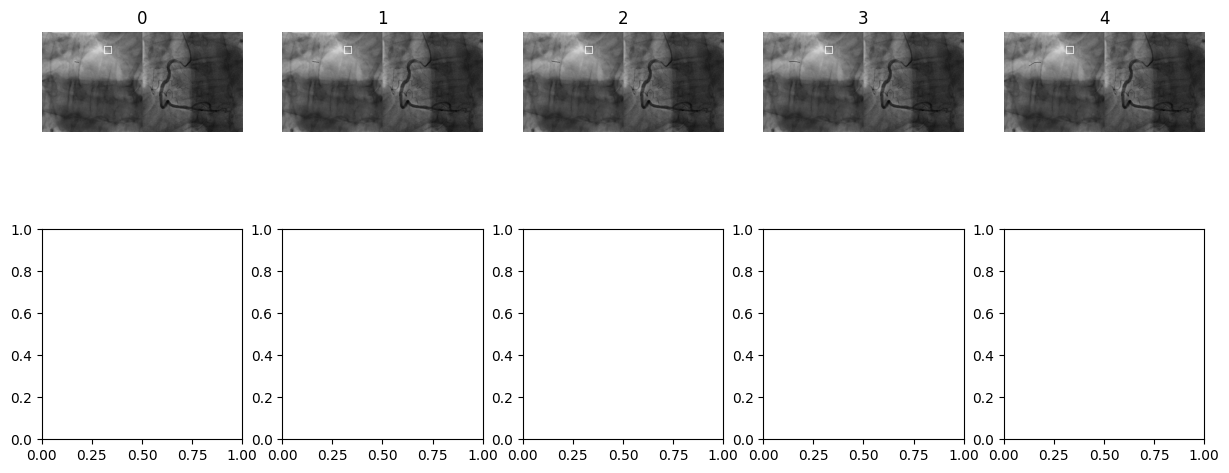

In [8]:
img_ploter(states, titles)

In [26]:
from networks.networks import MODEL_MAPPING

In [34]:
model = MODEL_MAPPING["HYBRID_RESNET18_VIT4"]()
input_image = dual_sync_transform(img, transform)
tensor = torch.from_numpy(input_image).unsqueeze(0)

model(tensor)

(tensor([[0.2148, 0.1700, 0.2673, 0.2972, 0.0507]], grad_fn=<SoftmaxBackward0>),
 tensor([[-0.0839]], grad_fn=<AddmmBackward0>))

([181, 173], [140, 359])

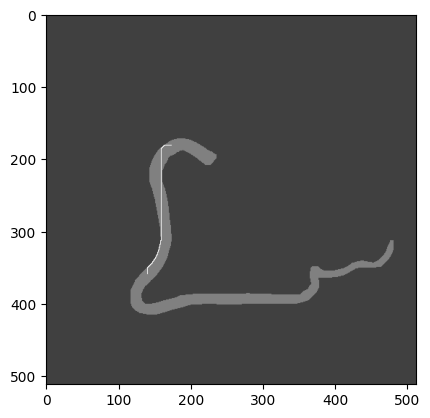

In [24]:
plt.imshow(env._mask_surf_np, cmap='gray', alpha=0.5)
plt.imshow(env.a_star_path_np, cmap='gray', alpha=0.5)

env.get_now_tip_pos(), env.metadata.target_pos

In [ ]:

import sys
# 全局定义训练环境
import matplotlib.pyplot as plt
import numpy as np 
from tqdm.notebook import tqdm
import torch
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib_inline import backend_inline
from IPython.display import HTML, clear_output
import os
backend_inline.set_matplotlib_formats('svg')
def display_video(frames:list, framerate:int=30, dpi:int=70):
    '''
        在Jupyter Notebook页面中生成视频
    '''
    height, width, _ = frames[0].shape
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg') 
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0], cmap='gray')
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

我们的目标是训练一个AI，能够根据图像输入学习到将导丝推送到目标位置（白框）

In [ ]:
from agents.ppo import Agent, ReplayData, ExperimentReplayBuffer
from networks.vit import VIT3_FC
from env.metadata import GuideSimMetadata, HyperParams
model = VIT3_FC()
count = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {count}")
agent = Agent(model)
agent.ac_model = model.to(agent.device)
hyper = HyperParams()
hyper.load_from_json("./hyper.json")
agent.set_hyperpara(hyper)
agent.plot_attrs()

## 需要尽可能的提升增加泛化性

这个仿真器提供了多种不同的任务，包括不同形状和大小的目标，不同难度的背景，不同难度的导丝路径

## 尝试使用Qwen2.5VL


In [70]:
from agents.qwen_vl import Agent

In [71]:
openai_api_key = "EMPTY"
openai_api_base = "http://192.168.1.110:1234/v1"
model="qwen2.5-vl-7b-instruct"
agent = Agent(openai_api_key, openai_api_base, model)

In [72]:
chat_response = agent.chat_with_array(img[0],
                    "将导丝递送到白框位置，你可以推进，后退，左转和右转，请输出你认为的导丝动作选择")  # 与agent对话
plt.imshow(img[0], cmap='gray')

APIConnectionError: Connection error.

In [18]:
chat_response.choices[0].message.content  # 获取回复内容

'根据图像显示的信息，导丝已经到达了白框的位置。因此，在这种情况下，不需要进行任何操作来移动或调整导丝。导丝已经在目标位置，可以保持不动。\n\n所以，正确的答案是：无需进行任何操作（即“静止”）。'

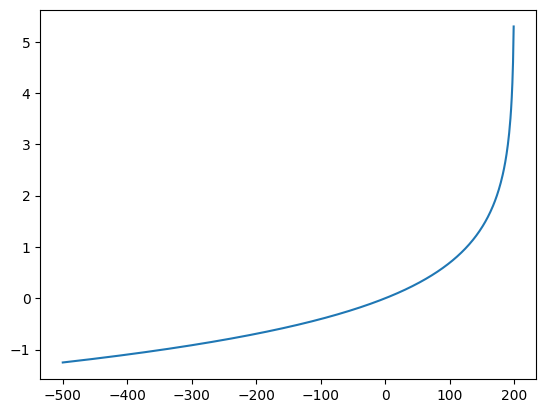

In [ ]:
import math
import numpy as np

def f(x):
    return np.log((200)) - np.log((-x + 200))
x = np.arange(-500, 200, 1)

plt.plot(x, f(x))


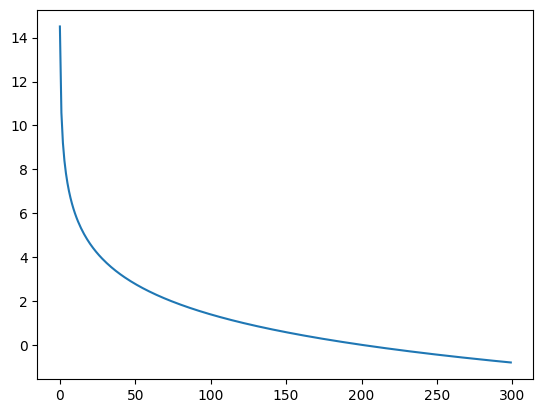

In [99]:
import numpy as np

def merged_formula(x):
    return np.log(200 / (( x ** 2 / 200 ) + 0.0001))

# x变为距离
x = np.arange(0, 300, 1)
plt.plot(x, merged_formula(x))

In [109]:
merged_formula(40)

3.218863324946325

# SoftTask测试

In [2]:
import matplotlib.pyplot as plt
import env.guide_sim_soft_task_ver as gs
import params
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib
from matplotlib import animation
import random
import os
import cv2

/home/umeko/miniconda3/envs/mhl/lib/python3.9/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


pygame 2.6.1 (SDL 2.28.4, Python 3.9.25)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
dataset_path = "datas/train/"
dataset_path = "datas/plastic_tube/"
tasks = os.listdir(os.path.join(dataset_path, "task"))
def _sortfunc(name:str):
    return int(name.split(".")[-2])
tasks.sort(key=_sortfunc)
tasks = [os.path.join(dataset_path, "task", t) for t in tasks]
env = gs.GuidewireEnv(tasks[0])

(1, 256, 256)


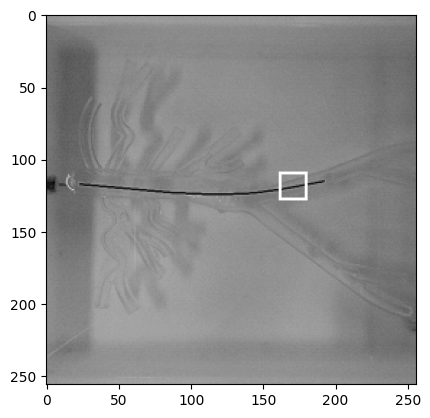

In [4]:
img = env.reset()  # 重置环境（每次要开始交互之前必须这么做）（输入代表根据序号开启某个任务）
print(img.shape)
plt.imshow(img[0], cmap='gray')

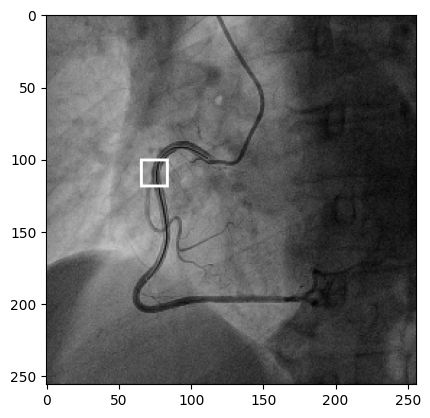

In [10]:
for i in range(5):
    s,_,d,_ = env.step(0)
    # if d == True:
    #     break
plt.imshow(s[0], cmap="gray")
plt.show()


In [4]:
fr = []
for i in range(100):
    s = env.reset()
    print(env.get_now_target_pos())
    fr.append(s[0])
display_video(fr)


is_collision False resampled_target (162.04421167312972, 191.75870107350767)
[191, 162]
is_collision False resampled_target (160.26215455165308, 188.12703903652184)
[188, 160]
is_collision False resampled_target (161.7911807574704, 189.8962035353793)
[189, 161]
is_collision False resampled_target (162.82800550664325, 209.1883100138512)
[209, 162]
is_collision False resampled_target (164.43867955241697, 203.57969168622367)
[203, 164]
is_collision False resampled_target (156.59430430787003, 207.85797070697154)
[207, 156]
is_collision False resampled_target (147.20455949328849, 214.0598464039118)
[214, 147]
is_collision False resampled_target (155.21497272284466, 188.9213312695131)
[188, 155]
is_collision False resampled_target (145.99380559789745, 209.22759460819967)
[209, 145]
is_collision False resampled_target (155.56418342772437, 198.86809119487992)
[198, 155]
is_collision False resampled_target (165.7729062410322, 183.01600262134235)
[183, 165]
is_collision False resampled_target (1

NameError: name 'display_video' is not defined

([366, 140], [150, 220])

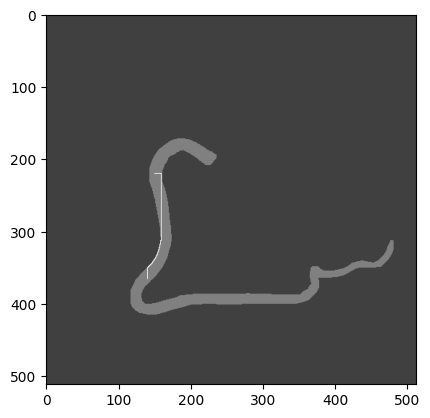

In [11]:
plt.imshow(env._mask_surf_np, cmap='gray', alpha=0.5)
plt.imshow(env.a_star_path_np, cmap='gray', alpha=0.5)

env.get_now_tip_pos(), env.metadata.target_pos

In [12]:
img = env._mask_surf_np.copy()
x, y = env.get_now_tip_pos()
pos = env.get_now_tip_pos()
pps = []
pps2 = []
pps3 = []
pps4 = []
def l2_distance_square(point1, point2):
    """
    没有开根的欧氏距离 (为了优化计算速度)
    """
    return (point1[0] - point2[0])**2 + (point1[1] - point2[1])**2

dist = 60
rejection_min_dist = max(4*env.metadata.radius, dist*0.5)
for _ in range(1000):
    pos = env.get_now_tip_pos()
    pos = (pos[0] + (1-np.random.normal(0, dist)), pos[1] + (1-np.random.normal(0, dist)))
    sampled_dist = l2_distance_square(pos, env.get_now_tip_pos())
    # 如果采样到的坐标离圆心太近，则拒绝采样
    if sampled_dist < rejection_min_dist**2:
        continue
    # 如果采样到的坐标在圆外，则依旧拒绝采样
    if sampled_dist > dist**2:
        continue
    if env._mask_surf_np[int(pos[0]), int(pos[1])] == 255:
        print(f"Sample goal: {l2_distance_square(pos, env.get_now_tip_pos()) ** 0.5}")
        pps.append(pos)
        # if env.line.point_side(pos):
        #     pps3.append(pos)
    
    samp = env.sample_goal(dist)
    if samp:
        pps2.append(samp)
        # if env.line.point_side(samp, 2):
        #     pps3.append(samp)
        
pps = np.array(pps)
pps2 = np.array(pps2)
pps3 = np.array(pps3)

pps2.shape

Sample goal: 50.93153712164002
Sample goal: 53.53774090683331
Sample goal: 41.97608146356647
Sample goal: 38.24578370823974
Sample goal: 35.24634067358218
Sample goal: 41.350534220437076
Sample goal: 32.1824814295982
Sample goal: 34.42963073309362
Sample goal: 43.80904863415753
Sample goal: 44.56529511886013
Sample goal: 35.3566335208059
Sample goal: 46.22630177090117
Sample goal: 51.96201196914063
Sample goal: 31.966558858120006
Sample goal: 48.89435362332684
Sample goal: 38.94125836086627
Sample goal: 43.5128128821606
Sample goal: 50.405210214368424
Sample goal: 45.34508750565583
Sample goal: 31.65638185968254
Sample goal: 44.88545677458554
Sample goal: 32.2858764706174
Sample goal: 52.98355226687228
Sample goal: 39.9021454180115
Sample goal: 34.16772142273971
Sample goal: 42.27926607452785
Sample goal: 41.36018819265814
Sample goal: 44.986390349732126
Sample goal: 52.37628401568159
Sample goal: 37.27607645639314
Sample goal: 48.60738810421717
Sample goal: 59.714050759318425
Sample g

(285, 2)

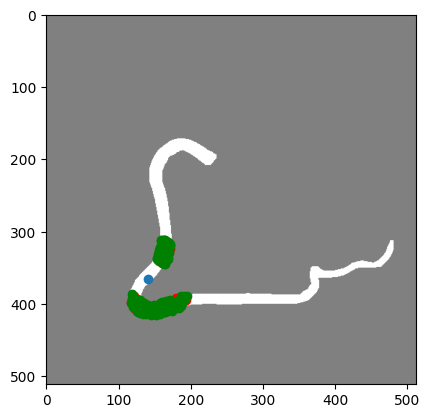

In [13]:
plt.imshow(img, cmap='gray', alpha=0.5)
plt.scatter(y, x)
plt.scatter(pps[:,1], pps[:,0], c='r')
plt.scatter(pps2[:,0], pps2[:,1], c='g')
# plt.scatter(pps3[:,0], pps3[:,1], c='b')
x1, y1 = env.metadata.insert_pos
x2, y2 = env.metadata.direct_pos
# plt.scatter(y, x)
# plt.scatter(x1, y1)
# plt.scatter(x2, y2)
plt.show()


In [ ]:
plt.imshow(img, cmap='gray', alpha=0.5)
plt.scatter(y, x)
# plt.scatter(pps[:,1], pps[:,0], c='r')
plt.scatter(pps2[:,0], pps2[:,1], c='g')
plt.scatter(y, x)
plt.show()


In [5]:
import matplotlib
from matplotlib import animation
from ipywidgets.widgets import HTML
def display_video(frames:list, framerate:int=30, dpi:int=70, channel_first:bool=True):
    '''
        在Jupyter Notebook页面中生成视频
    '''
    if len(frames[0].shape) == 2:
      height, width = frames[0].shape
    elif len(frames[0].shape) == 3:
      if channel_first:
        _, height, width = frames[0].shape
      else:
        height, width, _ = frames[0].shape
      height, width, _ = frames[0].shape
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg') 
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0], cmap='gray')
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

In [6]:
f = []
f.append(env.reset()[0])
for i in range(1000):
    a = random.randint(0, 3)
    s, r, d, _ = env.step(a)
    f.append(s[0])
    if d:
        print(r)
        f.append(env.reset()[0])

1.3299515269401678
-1.197312723787013
0.13798548787189455
2.744614046934678
2.8001731134205716
1.4944276308216238
-1.0964263647010601
2.0028955680843885
1.5463785727639843
-1.8196364608797633
-1.3291476535138613
1.4944276308216238
2.716244807814895
2.340140715178655
0.4823239979313035
1.7416553884351824
2.0829061755834872
2.772586500020028
-1.9317753705848062
-1.0204081112218944e-07
0.5283029986499779


In [8]:
display_video(f)

/tmp/ipykernel_2219745/759146711.py:19: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use(orig_backend)


HTML(value='<video width="364" height="364" controls autoplay>\n  <source type="video/mp4" src="data:video/mp4…